In [1]:
import numpy as np
from scipy import signal
import random
from numpy import linalg as LA
import librosa
import scipy.io.wavfile as wavfile
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.stats import multivariate_normal as mvn
import warnings
warnings.filterwarnings('ignore')
id2label = {0:'music', 1:'speech', 2:'laughter'}
label2id = {'music':0, 'speech':1, 'laughter':2}

In [2]:
# Define utility functions
# Code Reference: https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html
# The code in this cell is slightly modified for the actual implementation

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

def evaluate_model(confusion_matrix, model):
    correct = 0
    for i in range(3):
        correct += confusion_matrix[i,i]
    acc = correct/np.sum(confusion_matrix)
    print('Accuracy for {} is {}%'.format(model, acc*100))
    
    fig, ax = plt.subplots(figsize=(10,10))
    true_label = pred_label = [str(i) for i in range(3)]
    im, cbar = heatmap(confusion_matrix, true_label, pred_label, ax=ax, cmap="YlGn", cbarlabel="number of predictions")
    texts = annotate_heatmap(im)
    fig.tight_layout()
    plt.title('confusion matrix for {} classfier'.format(model))
    plt.xlabel('true label(left to right: music, speech, laughter)')
    plt.ylabel('predicting label(top to bottom: music, speech, laughter)')
    plt.show()

# Problem 1

For this problem, we try to build an audio classfier to distinguish music, speech and laughter by exploring three models: K-Means, GMM, and GMM-HMM. 

The input data is a 5-minute audio generating from Friends where music, speeches and laughters are interleaved. We first apply non-overlap 2048-STFT to the audio and then convert the spectrogram to 20-bin MFCCs. Therefore, the amount of data is equal to the number of time frames, while each data is 20-dimensional MFCCs of that frame. 

For each model, 90% of the time frames are trained and 10% are used as test data. Within the same time frame, if only one type of audio(music, speech or laughter), then it is labeled as that type. If more than one type of audio is involved, then the frame is labeled as the type the lasts the longest in the frame. We evaluate each model by computing its classfication accuracy on test data and corresponding confusion matrix.

In [3]:
# Preprocess data to generate MFCCs

# read audio and normalize it
sr, y = wavfile.read('friends.wav')
y = (y/np.max(y)).astype(float)
n_fft = 2048

# apply 2048-FFT and 30-bin MFCCs on each time frame
with open("labels.txt") as f:
    lines = [line.strip('\n').split('\t') for line in f]
features = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=2048, n_mfcc=30).T

# get labels for each data
labels = []
f_counter = 0
for i in range(len(features[:-1])):
    curr_end = i*n_fft+n_fft
    frame_end = float(lines[f_counter][1]) * sr
    if (curr_end-frame_end)>=(n_fft/2):
        f_counter += 1
    labels.append(lines[f_counter][2])

# get dataset for each type of audio
music, speech, laughter = [], [], []
for i, label in enumerate(labels):
    if i%10 != 0:
        if label=='music':
            music.append(features[i])
        elif label=='speech':
            speech.append(features[i])
        else:
            laughter.append(features[i])
            
train_data = [np.array(music), np.array(speech), np.array(laughter)]

## K-Means
The idea of K-Means model is we compute the mean of each cluster of the training dataset and cluster each test data to the cluster with closest mean measured by Euclidean distance. Due to simple implementation and intuitive logic behind the algorithm, K-Means serves as a good benchmark for building the classifier.

In [4]:
class K_Means:
    def __init__(self, train_data, cluster=3):
        self.train_data = train_data
        self.cluster = cluster
        self.dim = self.train_data[0].shape[1]
        self.means = np.zeros((self.cluster, self.dim))
    
    def train_model(self):
        for c in range(self.cluster):
            self.means[c] = np.mean(self.train_data[c], axis=0)
    
    def predict(self, x):
        d = []
        for m in self.means:
            d.append(np.sum(np.abs(x-m)))
        
        return np.argmin(d)

Accuracy for K-Means is 81.19658119658119%


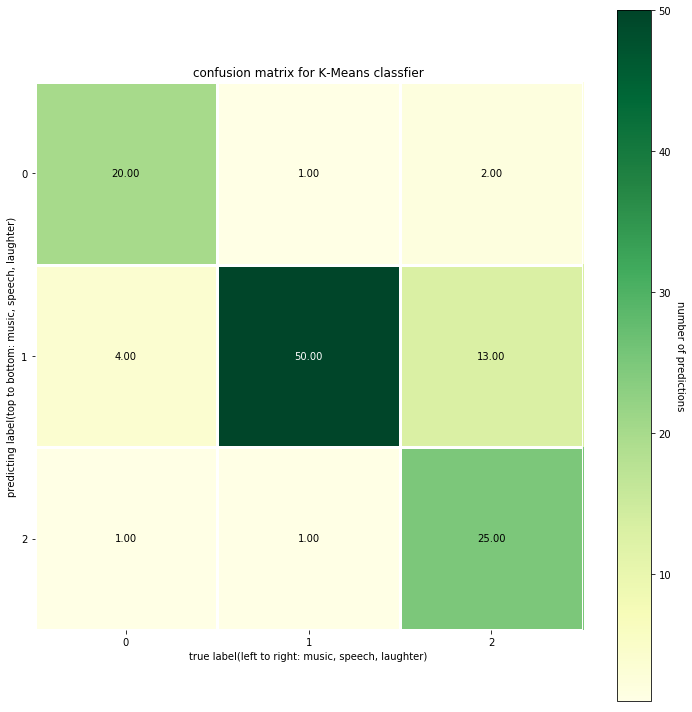

In [5]:
kmeans_model = K_Means(train_data)
kmeans_model.train_model()
kmeans_confusion_matrix = np.zeros((3,3))
for i, label in enumerate(labels):
    if i%10==0:
        x = features[i]
        pred_label = kmeans_model.predict(x)
        kmeans_confusion_matrix[label2id[label], pred_label]+=1
        
evaluate_model(kmeans_confusion_matrix, "K-Means")

## GMM
In GMM, we take a probabilistic approach to solve the same problem. We first compute the mean and covaraince of each class in the training dataset. During test, we assume all data can be modeled by multivariate Gaussian distribution, and calculate probability that each testing data belonging to a class given its mean and covariance. The predicted label will then be the cluster giving the highest probability.

In [6]:
class GMM:
    def __init__(self, train_data, cluster=3):
        self.train_data = train_data
        self.cluster = cluster
        self.dim = self.train_data[0].shape[1]
        self.means = np.zeros((self.cluster, self.dim))
        self.covs = np.zeros((self.cluster, self.dim, self.dim))
    
    def train_model(self):
        for c in range(self.cluster):
            self.means[c] = np.mean(self.train_data[c], axis=0)
            self.covs[c] = np.cov(self.train_data[c], rowvar=False)
    
    def predict(self, x):
        d = []
        for m,c in zip(self.means, self.covs):
            d.append(mvn.pdf(x,m,c,allow_singular = True))
        
        return np.argmax(d)

Accuracy for GMM is 90.5982905982906%


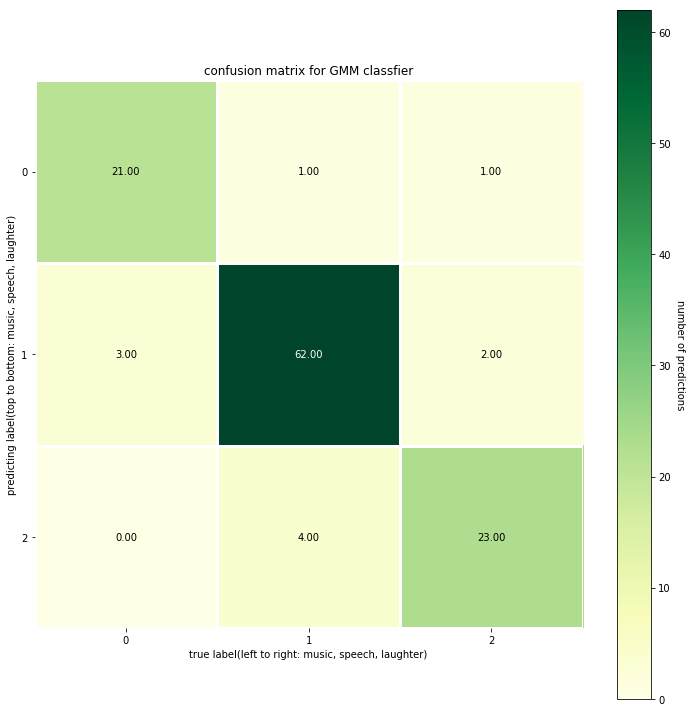

In [7]:
gmm_model = GMM(train_data)
gmm_model.train_model()
gmm_confusion_matrix = np.zeros((3,3))
for i, label in enumerate(labels):
    if i%10==0:
        x = features[i]
        pred_label = gmm_model.predict(x)
        gmm_confusion_matrix[label2id[label], pred_label]+=1 

evaluate_model(gmm_confusion_matrix, "GMM")

## HMM
HMM(Hidden Markov Model) can be used in speech recognition by comparing the probabilities that a sequence belongs to a particular class. For this problem, we use GMM-HMM to learn hidden features of each class and apply the trained model to classify test data. 

Assume there are N states. In the training process, we first randomly initialize the 1xN initial state probability $\pi$ and NxN transition matrix $\textbf{A}$. For this problem, we assume there are three states and initialize all probabilities of $\pi$ and $\textbf{A}$ to be $\frac{1}{3}$. Then, for each epoch, we traverse through the training sequence of a class and estimate $\alpha_{t}(i)$ and $\beta_{t}(i)$ for each frame t, where $\alpha_{t}(i)=P(o_{1},...o_{t}, i_{t}=q_{i})$ is the joint probability that frame t is at state $q_{i}$ and all previous observations $o_{1},...,o_{t}$ and $\beta_{t}(i)=P(o_{t+1},...o_{T}|i_{t}=q_{i})$ is the probability of all future observations $o_{t+1},...,o_{T}$ given frame t is at state $q_{i}$. We can also estimate the observation matrix $\textbf{B}$ of size TxK. $b_{t}(i)=P(o_{t}|i_{t}=q_{i})$ is the $(t,i)^{th}$ element of $\textbf{B}$, denoting the probability of observation of frame t given the frame is at state i.

With $\alpha_{t}(i)$ and $\beta_{t}(i)$, we further derive $\gamma_{t}(i)$ and $\xi_{t}(i,j)$, where $\gamma_{t}(i)=P(i_{t}=q_{i}|\textbf{O})=\frac{\alpha_{t}(i)\beta_{t}(i)}{\sum_{j=1}^{N}\alpha_{t}(j)\beta_{t}(j)}$ is the probability of frame t at state $q_{i}$ given all observations $\textbf{O}$ and $\xi_{t}(i,j)=P(i_{t}=q_{i}, i_{t}=q_{j}|\textbf{O})=\frac{\alpha_{t}(i)\textbf{A}_{ij}b_{t+1}(j)\beta_{t+1}{j}}{\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{t}(i)\textbf{A}_{ij}b_{t+1}(j)\beta_{t+1}{j}}$

To model the distribution of the training data, we assume the observation matrix has Gaussian distribution. We can initialize the mean $\mu$ and covariance $\Sigma$ as the mean and covariance of all data of the sequence. For each epoch, we update $\pi$, $\textbf{A}$, $\mu$ and $\Sigma$ according to the following equations:

$\pi^t(i)=\frac{\gamma^t(i)}{\sum_{j=1}^{N}\gamma^t(j)}$

$\textbf{A}^t(i,j)=\frac{\xi^t(i,j)}{\sum_{n=1}^{N}\sum_{m=1}^{N}\xi^t(n,m)}$

$\mu^t(i)=\frac{\sum_{t=1}^{T}x^{t}\gamma_{t}(i)}{\sum_{t=1}^{T}\gamma_{t}(i)}$

$\Sigma^t(i)=\frac{\sum_{t=1}^{T}(x^{t}-\mu^t(i))(x^{t}-\mu^t(i))^{T}\gamma_{t}(i)}{\sum_{t=1}^{T}\gamma_{t}(i)}$

By doing so, we successfully train our GMM-HMM model.

In [8]:
class Gaussian_HMM:
    def __init__(self, train_data, init_pi, init_A, K = 3, epoch = 20):
        self.train_data = train_data
        self.L = len(train_data)
        self.state = K
        self.pi = init_pi
        self.A = init_A
        self.mean = np.array([np.mean(np.vstack(train_data), axis = 0)] * K)
        self.cov = np.array([np.cov(np.vstack(train_data), rowvar = False)] * K)
        self.epoch = epoch
    
    def find_emission(self, x):
        T = x.shape[0]
        b = np.zeros((x.shape[0], self.state))
        for t in range(T):
            for k in range(self.state):
                b[t,k] = mvn.pdf(x[t],self.mean[k],self.cov[k],allow_singular = True)
                
        return b
    
    def forward(self, x, b):
        T = x.shape[0]
        alpha = np.zeros((T, self.state))
        g = np.zeros(T) # scaling factors
        alpha[0,:] = self.pi * b[0,:]
        g[0] = np.sum(alpha[0,:])
        alpha[0,:] = alpha[0,:] / g[0]
        for t in range(1,T):
            alpha_prev = np.dot(alpha[t-1].reshape(1,-1), self.A)
            alpha[t,:] = alpha_prev * b[t]
            g[t] = np.sum(alpha[t])
            alpha[t] = alpha[t] / g[t]
            
        return alpha, g
    
    def backward(self, x, b, g):
        T = x.shape[0]
        beta = np.zeros((T, self.state))
        beta[T-1, :] = np.ones(self.state)
        for t in reversed(range(T-1)):
            beta_next = beta[t+1] * b[t+1]
            beta[t] = np.dot(beta_next.reshape(1,-1),self.A.T)
            beta[t] = beta[t,:] / g[t+1]

        return beta
    
    def find_xi(self, x, b, g, alpha, beta):
        T = x.shape[0]
        xi = np.zeros((T-1, self.state, self.state))  
        for t in range(T-1):
            beta_next = beta[t+1] *  b[t+1]
            xi[t] = np.dot(alpha[t,:].reshape(-1,1),beta_next.reshape(1,-1))
            xi[t] =  xi[t] * self.A
            xi[t] =  xi[t]/ g[t+1] 
            
        return xi
        
    def find_gamma(self, alpha, beta):
        gamma = alpha * beta
        
        return gamma
    
    def train_model(self):    
        for it in range(self.epoch):
            alpha = []
            beta = []
            g = []
            xi = []
            gamma = []

            # E step
            for x_T in self.train_data:
                x = x_T.reshape((1,-1))
                b = self.find_emission(x)
                cur_alpha,cur_g = self.forward(x, b)
                cur_beta = self.backward(x, b, cur_g)
                cur_xi = self.find_xi(x, b, cur_g, cur_alpha, cur_beta)
                cur_gamma = self.find_gamma(cur_alpha, cur_beta)

                alpha.append(cur_alpha)
                beta.append(cur_beta)
                g.append(cur_g)
                xi.append(cur_xi)
                gamma.append(cur_gamma)

            # M step
            # re-estimates initial matrix
            for l in range(len(self.train_data)):
                cur_gamma = gamma[l]
                self.pi  += cur_gamma[0]
                self.pi = self.pi / np.sum(self.pi)

            # re-estimate transition matrix  
            for l in range(len(self.train_data)):
                cur_xi = xi[l]
                self.A += np.sum(cur_xi, axis = 0)
                self.A = self.A / np.sum(self.A, axis = 1, keepdims= True)

            # re-estimates means
            denom = np.zeros((self.state,1))
            num = np.zeros(self.mean.shape)
            for l in range(len(self.train_data)):
                cur_gamma = gamma[l]
                x = self.train_data[l].reshape((1,-1))
                denom += np.sum(cur_gamma, axis = 0).reshape(self.state,1)
                num += np.matmul(cur_gamma.T, x)
                self.mean = num/denom
            
            # re-estimates covariances
            denom = np.zeros((self.state, 1))
            num = np.zeros(self.cov.shape)
            for l in range(len(self.train_data)):
                cur_gamma = gamma[l]
                x = self.train_data[l].reshape((1,-1))
                denom += np.sum(cur_gamma, axis = 0).reshape(self.state,1)
                for k in range(self.state):
                    for t in range(x.shape[0]):
                        num[k] += cur_gamma[t,k] * np.dot((x[t] - self.mean[k]).reshape(-1,1), (x[t] - self.mean[k]).reshape(1,-1))
                self.cov[k] = num[k]/denom[k]
        
    def forward_predict(self, x):
        alpha = np.zeros(self.state)
        for k in range(self.state):
            alpha[k] = self.pi[k] * mvn.pdf(x, self.mean[k], self.cov[k], allow_singular=True)
        c = np.log(np.sum(alpha))

        return c

Accuracy for HMM is 92.3076923076923%


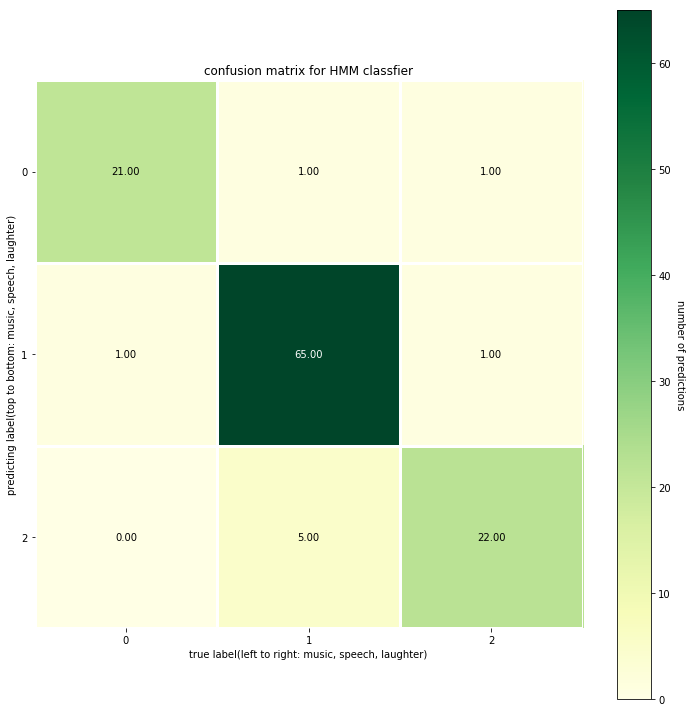

In [9]:
init_pi = np.array([1/3] * 3)
init_A = 1/3*np.ones((3,3))

music_hmm = Gaussian_HMM(music, init_pi, init_A)
speech_hmm = Gaussian_HMM(speech, init_pi, init_A)
laughter_hmm = Gaussian_HMM(laughter, init_pi, init_A)

music_hmm.train_model()
speech_hmm.train_model()
laughter_hmm.train_model()

hmm_confusion_matrix = np.zeros((3,3))
for i, label in enumerate(labels):
    if i%10==0:
        x = features[i]
        music_prob = music_hmm.forward_predict(x)
        speech_prob = speech_hmm.forward_predict(x)
        laughter_prob = laughter_hmm.forward_predict(x)
        pred_prob = np.array([music_prob, speech_prob, laughter_prob])
        hmm_confusion_matrix[label2id[label], np.argmax(pred_prob)]+=1
        
evaluate_model(hmm_confusion_matrix, "HMM")

As we can see from our result, GMM is better than the naive k-means, while GMM-HMM has the best performance in classifying audio data.